Interactive analysis with python
--------------------------------

Before starting this tutorial, ensure that you have set up _tangos_ [as described here](https://pynbody.github.io/tangos/) and the data sources [as described here](https://pynbody.github.io/tangos/data_exploration.html).

We get started by importing the modules we'll need:

In [1]:
%matplotlib inline
import pylab as p

import tangos

First let's inspect what simulations are available in our database:

In [2]:
tangos.all_simulations()

[<Simulation("tutorial_ramses")>,
 <Simulation("tutorial_gadget")>,
 <Simulation("tutorial_changa")>,
 <Simulation("tutorial_changa_blackholes")>]

For any of these simulations, we can generate a list of available timesteps as follows:

In [3]:
tangos.get_simulation("tutorial_changa").timesteps

[<TimeStep 'tutorial_changa/pioneer50h128.1536gst1.bwK1.000384' z=4.57 t=1.31 Gyr>,
 <TimeStep 'tutorial_changa/pioneer50h128.1536gst1.bwK1.000448' z=4.03 t=1.53 Gyr>,
 <TimeStep 'tutorial_changa/pioneer50h128.1536gst1.bwK1.000640' z=2.96 t=2.17 Gyr>,
 <TimeStep 'tutorial_changa/pioneer50h128.1536gst1.bwK1.000832' z=2.32 t=2.82 Gyr>,
 <TimeStep 'tutorial_changa/pioneer50h128.1536gst1.bwK1.000960' z=2.02 t=3.25 Gyr>]

For any timestep, we can access the halos using `.halos` and a specific halo using standard python 0-based indexing:

In [4]:
tangos.get_simulation("tutorial_changa").timesteps[3].halos[3]

<Halo 'tutorial_changa/pioneer50h128.1536gst1.bwK1.000832/halo_4' | NDM=199525 Nstar=7531 Ngas=19920>

One can skip straight to getting a specific halo as follows:

In [5]:
tangos.get_halo("tutorial_changa/%384/halo_4")

<Halo 'tutorial_changa/pioneer50h128.1536gst1.bwK1.000384/halo_4' | NDM=87599 Nstar=1900 Ngas=9220>

Note the use of the SQL wildcard % character which avoids us having to type out the entire path. Whatever way you access it, the resulting object allows you to query what properties have been calculated for that specific halo. We can then access those properties using the normal python square-bracket dictionary syntax.

In [6]:
halo = tangos.get_halo("tutorial_changa/%960/halo_1")
halo.keys()

['contamination_fraction',
 'shrink_center',
 'max_radius',
 'dm_density_profile',
 'dm_mass_profile',
 'gas_density_profile',
 'gas_mass_profile',
 'star_density_profile',
 'star_mass_profile',
 'gas_map_sideon',
 'uvi_image_sideon',
 'gas_map_faceon',
 'uvi_image_faceon',
 'gas_map',
 'uvi_image',
 'SFR_histogram',
 'Mvir',
 'Rvir',
 'ptcls_in_common',
 'ptcls_in_common',
 'ptcls_in_common',
 'ptcls_in_common',
 'ptcls_in_common',
 'ptcls_in_common',
 'ptcls_in_common']

In [7]:
halo['Mvir']

637727000000.0

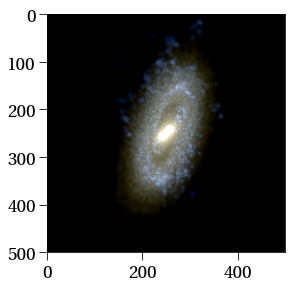

In [8]:
p.imshow(halo['uvi_image'])

One can also get meta-information about the computed property. It would be nice to know
the physical size of the image we just plotted. We retrieve the underlying property object
and ask it:

In [9]:
halo.get_description("uvi_image").plot_extent()

15.0

This tells us that the image is 15 kpc across. The example properties that come with _tangos_
use _pynbody_'s units system to convert everything to physical kpc, solar masses and km/s. When
you implement your own properties, you can of course store them in whichever units you like.

Getting a time sequence of properties
-------------------------------------

Often we would like to see how a property varies over time. _Tangos_ provides convenient ways to extract this information, automatically finding 
major progenitors or descendants for a halo. Let's see this illustrated on the SubFind _mass_ property:

[]

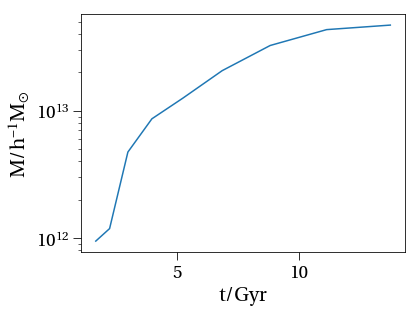

In [10]:
halo = tangos.get_halo("tutorial_gadget/snapshot_020/halo_10")

# Calculate on major progenitor branch:
Mvir, t = halo.calculate_for_progenitors("mass","t()")

# Now perform plotting:
p.plot(t,1e10*Mvir)
p.xlabel("t/Gyr")
p.ylabel(r"$M/h^{-1} M_{\odot}$")
p.semilogy()

In the example above, `calculate_for_progenitors` retrieves properties on the major progenitor branch of the chosen halo. One can ask for as many properties as you like, each one being returned as a numpy array in order. In this particular example the first property is the mass (as reported by subfind) and the second is the time. In fact the second property isn't really stored - if you check `halo.keys()` you won't find `t` in there. It's a simple example of a _live property_ which means it's calculated on-the-fly from other data. The time is actually stored in the TimeStep rather than the Halo database entry, so the `t()` live property simply retrieves it from the appropriate location.

Live properties are a powerful aspect of _tangos_. We'll see more of them momentarily.

Histogram properties
--------------------

While the approach above is the main way to get time series of data with _tangos_, sometimes one
wants to be able to use finer time bins than the number of outputs available. For example, star
formation rates or black hole accretion rates often vary on short timescales and the output files
from simulations are sufficient to reconstruct these variations in between snapshots.

_Tangos_ implements `TimeChunkedHistogram` for this purpose. As the name suggests, a _chunk_ of
historical data is stored with each timestep. The full history is then reconstructed by combining
the chunks through the merger tree; this process is customizable. Let's start with the simplest
possible request:

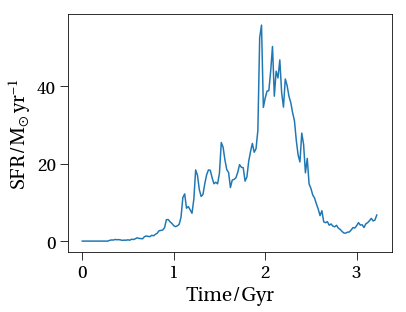

In [11]:
halo = tangos.get_halo("tutorial_changa_blackholes/%960/halo_1")
SFR = halo["SFR_histogram"]

# The above is sufficient to retrieve the histogram; however you probably also want to check
# the size of the time bins. The easiest approach is to request a suitable time array to go with
# the SF history:
SFR_property_object = halo.get_objects("SFR_histogram")[0]
SFR_time_bins = SFR_property_object.x_values()

p.plot(SFR_time_bins, SFR)
p.xlabel("Time/Gyr")
p.ylabel(r"SFR/$M_{\odot}\,yr^{-1}$")

The advantage of storing the histogram in chunks is that one can reconstruct it
in different ways. The default is to go along the major progenitor branch, but
one can also sum over all progenitors. The following code shows the fraction of
star formation in the major progenitor:

/Users/app/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


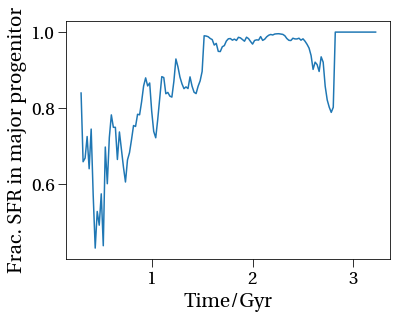

In [12]:
SFR_all = halo.calculate('reassemble(SFR_histogram, "sum")')
p.plot(SFR_time_bins, SFR/SFR_all)
p.xlabel("Time/Gyr")
p.ylabel("Frac. SFR in major progenitor")

_Technical note_: It's worth being aware that the merger information is, of course, quantized to the
output timesteps even though the SFR information is stored in small chunks. This is rarely an issue
but with coarse timesteps (such as those in the tutorial simulations), the quantization can cause
noticable artefacts – here, the jump to 100% in the major progenitor shortly before _t_ = 3 Gyr 
corresponds to the time of the penultimate stored step, after which no mergers are recorded. 

For more information, see the [time-histogram properties](https://pynbody.github.io/tangos/histogram_properties.html) page.

Let's see another example of a histogram property: the black hole accretion rate 

/Users/app/Science/tangos/tangos/live_calculation/__init__.py:585: RuntimeWarning: More than one relation for target 'BH' has been found. Picking the first.
  warnings.warn("More than one relation for target %r has been found. Picking the first."%str(self.locator), RuntimeWarning)


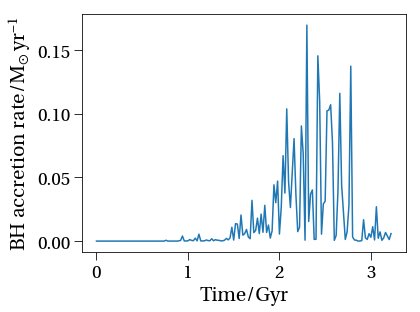

In [13]:
BH_accrate = halo.calculate('BH.BH_mdot_histogram')
p.plot(SFR_time_bins, BH_accrate)
p.xlabel("Time/Gyr")
p.ylabel(r"BH accretion rate/$M_{\odot}\,yr^{-1}$")

This works fine, but you may have noticed the warning that more than one black hole
is in the halo of interest. There is more information about the way that links between
objects work in _tangos_, and disambiguating between them, in the "using links" section
below.

Getting properties for multiple halos
-------------------------------------

Quite often one wants to collect properties from multiple halos simultaneously. Suppose we want to plot the mass against the vmax for all halos at
a specific snapshot:

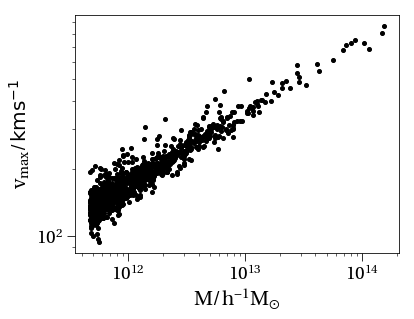

In [14]:
timestep = tangos.get_timestep("tutorial_gadget/snapshot_019")
mass, vmax = timestep.calculate_all("mass","VMax")

p.plot(mass*1e10,vmax,'k.')
p.loglog()
p.xlabel(r"$M/h^{-1} M_{\odot}$")
p.ylabel(r"$v_{max}/{\rm km s^{-1}}$")

Often when querying multiple halos we still want to know something about their history, and live calculations enable that. Suppose we want to know how much the mass has grown since the previous snapshot:

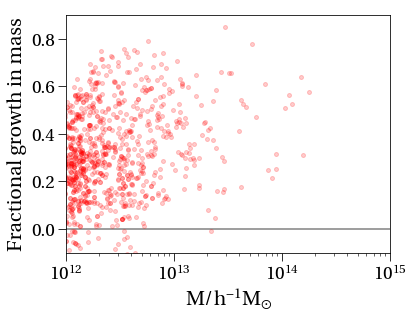

In [15]:
mass, fractional_delta_2 = timestep.calculate_all("mass",  "(mass-earlier(2).mass)/mass")

p.hlines(0.0,1e10,1e15, colors="gray")
p.plot(mass*1e10, fractional_delta_2,"r.", alpha=0.2)
p.semilogx()
p.ylim(-0.1,0.9)
p.xlim(1e12,1e15)
p.xlabel(r"$M/h^{-1} M_{\odot}$")
p.ylabel("Fractional growth in mass")

This is a much more ambitious use of the live calculation system. Consider the last property retrieved, which is `(mass-earlier(2).mass)/mass`. This combines algebraic operations with _redirection_: `earlier(2)` finds the major progenitor two steps prior to this one, after which `.mass` retrieves the mass at that earlier timestep. This is another example of a "link", as previously used to retrieve
black hole information above.


Using Links
-----------

_Tangos_ has a concept of "links" between objects including halos and black holes. For example,
the merger tree information that you have already used indirectly is stored as links. 

Returning to our example of black holes above, we used a link named `BH`; however this issued a
warning that the result was technically ambiguous. Let's see that warning again. For clarity,
we will use the link named `BH_central` this time around -- it's an alternative set of links
which only includes black holes associated with the central galaxy (rather than any satellites).

In [16]:
halo = tangos.get_halo("tutorial_changa_blackholes/%960/halo_1")
BH_mass = halo.calculate('BH_central.BH_mass')

/Users/app/Science/tangos/tangos/live_calculation/__init__.py:585: RuntimeWarning: More than one relation for target 'BH_central' has been found. Picking the first.
  warnings.warn("More than one relation for target %r has been found. Picking the first."%str(self.locator), RuntimeWarning)


We still get the warning, so there's more than one black hole in the central galaxy.

To avoid such warnings, you can specify more about which link you are referring to. For example,
we can specifically ask for the black hole with the _largest mass_ and _smallest impact parameters_
using the following two queries:

In [17]:
BH_max_mass = halo.calculate('link(BH_central, BH_mass, "max")')
BH_closest = halo.calculate('link(BH_central, BH_central_distance, "min")')

The `link` live-calculation function returns the halo with either the maximum or minimum value of an
associated property, here the `BH_mass` and `BH_central_distance` properties respectively. 
Either approach disambiguates the black holes we mean (in fact, they unsurprisingly lead to
the same disambiguation):

In [18]:
BH_max_mass == BH_closest

True

However one doesn't always have to name a link to make use of it. The mere existence of a link
is sometimes enough. An example is the merger tree information already used. Another useful
example is when two simulations have the same initial conditions, as in the `tutorial_changa`
and `tutorial_changa_blackholes` examples; these two simulations differ only in that the latter
has AGN feedback. We can identify halos between simulations using the following syntax:

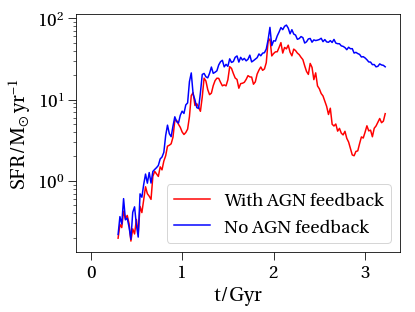

In [19]:
SFR_in_other_sim = halo.calculate("match('tutorial_changa').SFR_histogram")
p.plot(SFR_time_bins, halo['SFR_histogram'],color='r', label="With AGN feedback")
p.plot(SFR_time_bins, SFR_in_other_sim, color='b',label="No AGN feedback")
p.legend(loc="lower right")
p.semilogy()
p.xlabel("t/Gyr")
p.ylabel(r"SFR/$M_{\odot}\,yr^{-1}$")

The `match` syntax simply tries to follow links until it finds a halo in the named
_tangos_ context. One can use it to match halos across entire timesteps too; let's
compare the stellar masses of our objects:

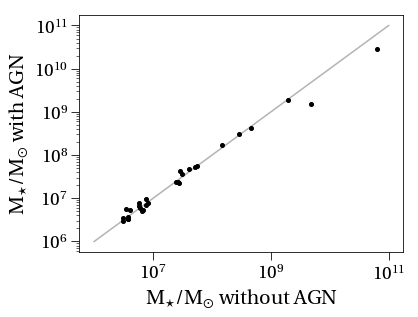

In [20]:
timestep = tangos.get_timestep("tutorial_changa/%960")
Mstar_no_AGN, Mstar_AGN = timestep.calculate_all("star_mass_profile[-1]", 
                                                 "match('tutorial_changa_blackholes').star_mass_profile[-1]")
# note that we use star_mass_profile[-1] to get the last entry of the star_mass_profile array,
# as a means to get the total stellar mass from a profile
p.plot(Mstar_no_AGN, Mstar_AGN, 'k.')
p.plot([1e6,1e11],[1e6,1e11],'k-',alpha=0.3)
p.loglog()
p.xlabel(r"$M_{\star}/M_{\odot}$ without AGN")
p.ylabel(r"$M_{\star}/M_{\odot}$ with AGN")